In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from loss import FocalLoss, BinaryDiceLoss
from utils import normalize
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import os
import random
import numpy as np
from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from visualization import visualizer

from metrics import image_level_metrics, pixel_level_metrics, image_level_threshold
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

---
# AnomalyCLIP

In [3]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--data_path", type=str, default="./data/mvtec", help="path to test dataset")
parser.add_argument("--save_path", type=str, default='./results/CP/mvtec_pixel', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./checkpoints/9_12_4_multiscale/epoch_15.pth', help='path to checkpoint')
# model
parser.add_argument("--dataset", type=str, default='mvtec')
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--metrics", type=str, default='image-pixel-level')
parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

args = parser.parse_args(args=[])

In [5]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device ===> {device}')
AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list
print(f'obj_list ===> {obj_list}\n')

train_results = {}
train_metrics = {}
for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []
    train_metrics[obj] = {}
    train_metrics[obj]['pixel-auroc'] = 0
    train_metrics[obj]['pixel-aupro'] = 0
    train_metrics[obj]['image-auroc'] = 0
    train_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

device ===> cuda
name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** train ********************** 

obj_list ===> ['carpet', 'wood', 'metal_nut', 'toothbrush']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


In [4]:
train_results['wood']['gt_sp']

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 ten

---
# CP

In [5]:
# # Problem setup
# n=21 # number of calibration points
# alpha = 0.1 # 1-alpha is the desired coverage

# smx = np.array(list(zip(results['toothbrush']['pr_sp_n'], results['toothbrush']['pr_sp'])))
# labels = np.array(results['toothbrush']['gt_sp'])
# smx

In [6]:
# # Split the softmax scores into calibration and validation sets (save the shuffling)
# idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
# np.random.shuffle(idx)
# cal_smx, val_smx = smx[idx], smx[~idx]
# cal_labels, val_labels = labels[idx], labels[~idx]

# print(idx)
# print(cal_labels)
# print(val_labels)

In [7]:
# cal_smx

In [8]:
# # 1: get conformal scores. n = calib_Y.shape[0]
# cal_scores = 1-cal_smx[np.arange(n), cal_labels]
# cal_scores

In [9]:
# # 2: get adjusted quantile
# q_level = np.ceil((n+1)*(1-alpha))/n
# qhat = np.quantile(cal_scores, q_level, method='higher')
# prediction_sets = val_smx >= (1-qhat) # 3: form prediction sets

In [10]:
# # Calculate empirical coverage
# empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
# print(f"The empirical coverage is: {empirical_coverage}")

---
# Outlier

In [6]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list

test_results = {}
test_metrics = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []
    test_metrics[obj] = {}
    test_metrics[obj]['pixel-auroc'] = 0
    test_metrics[obj]['pixel-aupro'] = 0
    test_metrics[obj]['image-auroc'] = 0
    test_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 353/353 [02:17<00:00,  2.56it/s]


### 1. train data에서 q_hat 계산

In [9]:
scores = np.array(train_results['carpet']['pr_sp'])  # train dataset

n = len(scores)
alpha = 0.1
q_level = np.ceil((n+1)*(1-alpha))/n 
train_qhat = np.quantile(scores, q_level, method='higher')
print(f'n ===> {n}')
print(f'q_level ===> {q_level}')
print(f'train_qhat ===> {train_qhat}')

n ===> 280
q_level ===> 0.9035714285714286
train_qhat ===> 0.25365903973579407


In [10]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = (test_results['carpet']['pr_sp'] > train_qhat)
for t, p in zip(y_true, y_scores):
    print(t, ':', p)
# print(f'y_true ===> \n{y_true} \n\ny_scores ===> \n{y_scores}')

1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : True
0 : True
0 : True
0 : False
0 : False
0 : False
0 : True
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : 

In [11]:
p = precision_score(y_true, y_scores)
r = recall_score(y_true, y_scores)


print(f'precision: {round(p, 3)} \nrecall: {round(r, 3)}')

precision: 0.957 
recall: 1.0


In [12]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

print(len(scores), len(y_true), len(y_score_list), end='\n')

807 353 353


In [13]:
for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = ( y_score_list > train_qhat)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

train_qhat: 0.9858862161636353 
precision: 0.9603 
recall: 0.5331


### 2. calibration data (only normal)

In [14]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = np.array(test_results['carpet']['pr_sp'])

y_all = sorted(list(zip(y_true, y_scores)))
print(y_all)

[(0, 0.17128347), (0, 0.17522913), (0, 0.18888567), (0, 0.1953873), (0, 0.19682331), (0, 0.19742927), (0, 0.20378216), (0, 0.20381261), (0, 0.20465273), (0, 0.20693024), (0, 0.20695265), (0, 0.20697682), (0, 0.20836677), (0, 0.21105494), (0, 0.21405418), (0, 0.21410057), (0, 0.21462946), (0, 0.22497368), (0, 0.23117892), (0, 0.23289624), (0, 0.23614268), (0, 0.24377878), (0, 0.24430126), (0, 0.2482155), (0, 0.2641099), (0, 0.26810297), (0, 0.27282953), (0, 0.29031515), (1, 0.28140315), (1, 0.3079043), (1, 0.31856352), (1, 0.392282), (1, 0.39272735), (1, 0.39417228), (1, 0.40466717), (1, 0.40509227), (1, 0.41140708), (1, 0.42897922), (1, 0.43200743), (1, 0.46275836), (1, 0.49084774), (1, 0.530131), (1, 0.5315469), (1, 0.5483669), (1, 0.5552129), (1, 0.5572467), (1, 0.58006865), (1, 0.59770864), (1, 0.59911597), (1, 0.62391824), (1, 0.6344057), (1, 0.63594115), (1, 0.6595528), (1, 0.66139066), (1, 0.6657083), (1, 0.6809939), (1, 0.6889159), (1, 0.6955137), (1, 0.71222687), (1, 0.7358459)

##### class 1개


In [15]:
n = 10
alpha = 0.1 # 1-alpha is the desired coverage

p_list = []
r_list = []

for i in range(19):
    score_list = np.array(y_all[i:i + 10])[:, 1]
    y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
    y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

    q_level = np.ceil((n+1)*(1-alpha))/n 
    qhat = np.quantile(score_list, q_level, method='higher')
    
    y_pred = y_pred_list > qhat

    # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
    print(f'{i}\n{(y_label), (y_pred)}')

    p = precision_score(y_label, y_pred)
    p_list.append(p)

    r = recall_score(y_label, y_pred)
    r_list.append(r)

print(f'precision: {round(sum(p_list)/len(p_list), 3)} \nrecall: {round(sum(r_list)/len(r_list), 3)}')

0
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, 

##### 전체 데이터 (각 클래스 별)

In [16]:
cali_only_nor_res = {}
for obj in obj_list:
    y_true = np.array(test_results[obj]['gt_sp'])
    y_scores = np.array(test_results[obj]['pr_sp'])

    y_all = sorted(list(zip(y_true, y_scores)))
    n = 10
    alpha = 0.1 # 1-alpha is the desired coverage

    p_list = []
    r_list = []

    for i in range(len(np.where(y_true == 0))):
        score_list = np.array(y_all[i:i + 10])[:, 1]
        y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred)
        p_list.append(p)

        r = recall_score(y_label, y_pred)
        r_list.append(r)

    cali_only_nor_res[obj] = (sum(p_list)/len(p_list), sum(r_list)/len(r_list))

print(cali_only_nor_res)

{'carpet': (0.8317757009345794, 1.0), 'wood': (0.8656716417910447, 0.9666666666666667), 'metal_nut': (0.883495145631068, 0.978494623655914), 'toothbrush': (0.9166666666666666, 0.7333333333333333)}


##### 모든 클래스 통합

In [17]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))


In [18]:
normal_all_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.8625 
recall: 0.7447


15
qhat 0.9893184304237366
precision: 0.8674 
recall: 0.7253


20
qhat 0.9893184304237366
precision: 0.8722 
recall: 0.7028


25
qhat 0.9893184304237366
precision: 0.8767 
recall: 0.6763


30
qhat 0.9884844422340393
precision: 0.8824 
recall: 0.6555


35
qhat 0.9884844422340393
precision: 0.8895 
recall: 0.6393


40
qhat 0.9876382350921631
precision: 0.898 
recall: 0.6305


45
qhat 0.9876382350921631
precision: 0.9064 
recall: 0.6154


50
qhat 0.987127423286438
precision: 0.9164 
recall: 0.6083


55
qhat 0.987127423286438
precision: 0.9265 
recall: 0.5947




##### abnormal 개수 122

In [19]:
import random
# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 150)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

normal_122_qhat = []

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_122_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.7424 
recall: 0.7426


15
qhat 0.9893184304237366
precision: 0.7502 
recall: 0.7231


20
qhat 0.9893184304237366
precision: 0.758 
recall: 0.7003


25
qhat 0.9893184304237366
precision: 0.7655 
recall: 0.6736


30
qhat 0.9884844422340393
precision: 0.775 
recall: 0.6525


35
qhat 0.9884844422340393
precision: 0.7873 
recall: 0.6379


40
qhat 0.9876382350921631
precision: 0.802 
recall: 0.6297


45
qhat 0.9876382350921631
precision: 0.8163 
recall: 0.6143


50
qhat 0.987127423286438
precision: 0.8342 
recall: 0.6079


55
qhat 0.987127423286438
precision: 0.852 
recall: 0.5939




In [20]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 172)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

normal_100_qhat = []

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_100_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.7059 
recall: 0.7458


15
qhat 0.9893184304237366
precision: 0.7146 
recall: 0.7265


20
qhat 0.9893184304237366
precision: 0.7232 
recall: 0.7041


25
qhat 0.9893184304237366
precision: 0.7316 
recall: 0.6777


30
qhat 0.9884844422340393
precision: 0.7424 
recall: 0.6571


35
qhat 0.9884844422340393
precision: 0.7546 
recall: 0.6378


40
qhat 0.9876382350921631
precision: 0.7701 
recall: 0.6268


45
qhat 0.9876382350921631
precision: 0.786 
recall: 0.6108


50
qhat 0.987127423286438
precision: 0.8056 
recall: 0.6039


55
qhat 0.987127423286438
precision: 0.8257 
recall: 0.5892




### 3. calibraion data (all) 

##### class 1개

In [21]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = np.array(test_results['carpet']['pr_sp'])

y_all = list(zip(y_true, y_scores))

n = 10
alpha = 0.1 # 1-alpha is the desired coverage

p_list_all = []
r_list_all = []

for i in range(len(y_true)-10):
    score_list = np.array(y_all[i:i + 10])[:, 1]
    y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
    y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

    q_level = np.ceil((n+1)*(1-alpha))/n 
    qhat = np.quantile(score_list, q_level, method='higher')
    
    y_pred = y_pred_list > qhat

    # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
    print(f'{i}\n{len(y_label), y_label,  len(y_pred), y_pred}')

    p = precision_score(y_label, y_pred)
    p_list_all.append(p)

    r = recall_score(y_label, y_pred)
    r_list_all.append(r)

print(f'precision: {round(sum(p_list_all)/len(p_list_all), 3)} \nrecall: {round(sum(r_list_all)/len(r_list_all), 3)}')

0
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

69
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fal

##### 전체 데이터 (클래스별로)

In [22]:
cali_all_res = {}
for obj in obj_list:
    y_true = np.array(test_results[obj]['gt_sp'])
    y_scores = np.array(test_results[obj]['pr_sp'])

    y_all = list(zip(y_true, y_scores))

    n = 10
    alpha = 0.1 # 1-alpha is the desired coverage

    p_list_all = []
    r_list_all = []

    for i in range(len(y_true)-10):
        score_list = np.array(y_all[i:i + 10])[:, 1]
        y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        
        y_pred = y_pred_list > qhat

        # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
        print(f'{i}\n{len(y_label), y_label,  len(y_pred), y_pred}')

        p = precision_score(y_label, y_pred)
        p_list_all.append(p)

        r = recall_score(y_label, y_pred)
        r_list_all.append(r)
    print(obj, y_pred, '\n', len(p_list_all), len(r_list_all), '\n')

    cali_all_res[obj] = (sum(p_list_all)/len(p_list_all), sum(r_list_all)/len(r_list_all))

print(cali_all_res)

0
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

66
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fal

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

23
(105, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.]), 105, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 클래스 통합 (전체)

In [23]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = np.array(list(zip(y_true, y_score_list)))
# y_all = np.array(y_all)


In [24]:
alpha = 0.1 # 1-alpha is the desired coverage

# print(f'y_all \n{len(y_all)}\n{y_all}')
# print(np.array(y_all).shape)

all_all_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.9217 
recall: 0.3993


---15---
precision: 0.9145 
recall: 0.3651


---20---
precision: 0.9041 
recall: 0.3355


---25---
precision: 0.8911 
recall: 0.3146


---30---
precision: 0.9579 
recall: 0.3367


---35---
precision: 0.9451 
recall: 0.3172


---40---
precision: 0.9592 
recall: 0.3174


---45---
precision: 0.9621 
recall: 0.3003


---50---
precision: 0.9622 
recall: 0.2993


---55---
precision: 0.9645 
recall: 0.285




##### abnormal 122 개

In [25]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))
# y_all = np.array(y_all)

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 150)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]
y_all = np.array(y_all)


all_122_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_122_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.8448 
recall: 0.4405


---15---
precision: 0.8359 
recall: 0.3907


---20---
precision: 0.8182 
recall: 0.3431


---25---
precision: 0.7946 
recall: 0.3087


---30---
precision: 0.7682 
recall: 0.3131


---35---
precision: 0.7423 
recall: 0.2824


---40---
precision: 0.9416 
recall: 0.2788


---45---
precision: 0.9454 
recall: 0.2516


---50---
precision: 0.9164 
recall: 0.2449


---55---
precision: 0.8912 
recall: 0.2161




##### abnormal 100개

In [26]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))
# y_all = np.array(y_all)

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 172)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]
y_all = np.array(y_all)

all_100_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_100_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.8388 
recall: 0.4422


---15---
precision: 0.8313 
recall: 0.3793


---20---
precision: 0.8121 
recall: 0.3243


---25---
precision: 0.7881 
recall: 0.2793


---30---
precision: 0.9405 
recall: 0.2978


---35---
precision: 0.9455 
recall: 0.2642


---40---
precision: 0.917 
recall: 0.2523


---45---
precision: 0.8921 
recall: 0.2195


---50---
precision: 0.8608 
recall: 0.2062


---55---
precision: 0.8297 
recall: 0.1644




---
# Plot
### 1. Score(scatter plot)

In [32]:
print(test_results.keys())
print(test_results['carpet'].keys())

color_list = ['orange', 'tomato', 'grey', 'lightsteelblue']

dict_keys(['carpet', 'wood', 'metal_nut', 'toothbrush'])
dict_keys(['gt_sp', 'pr_sp', 'pr_sp_n', 'imgs_masks', 'anomaly_maps'])


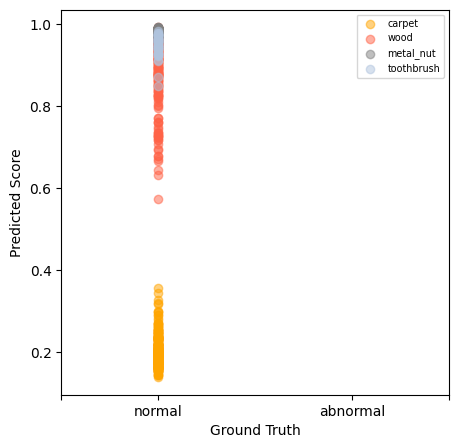

In [33]:
# train
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

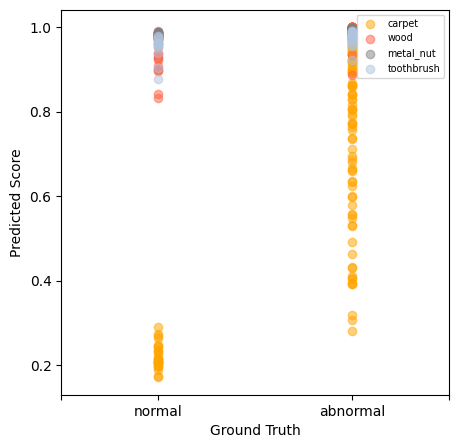

In [34]:
# test
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

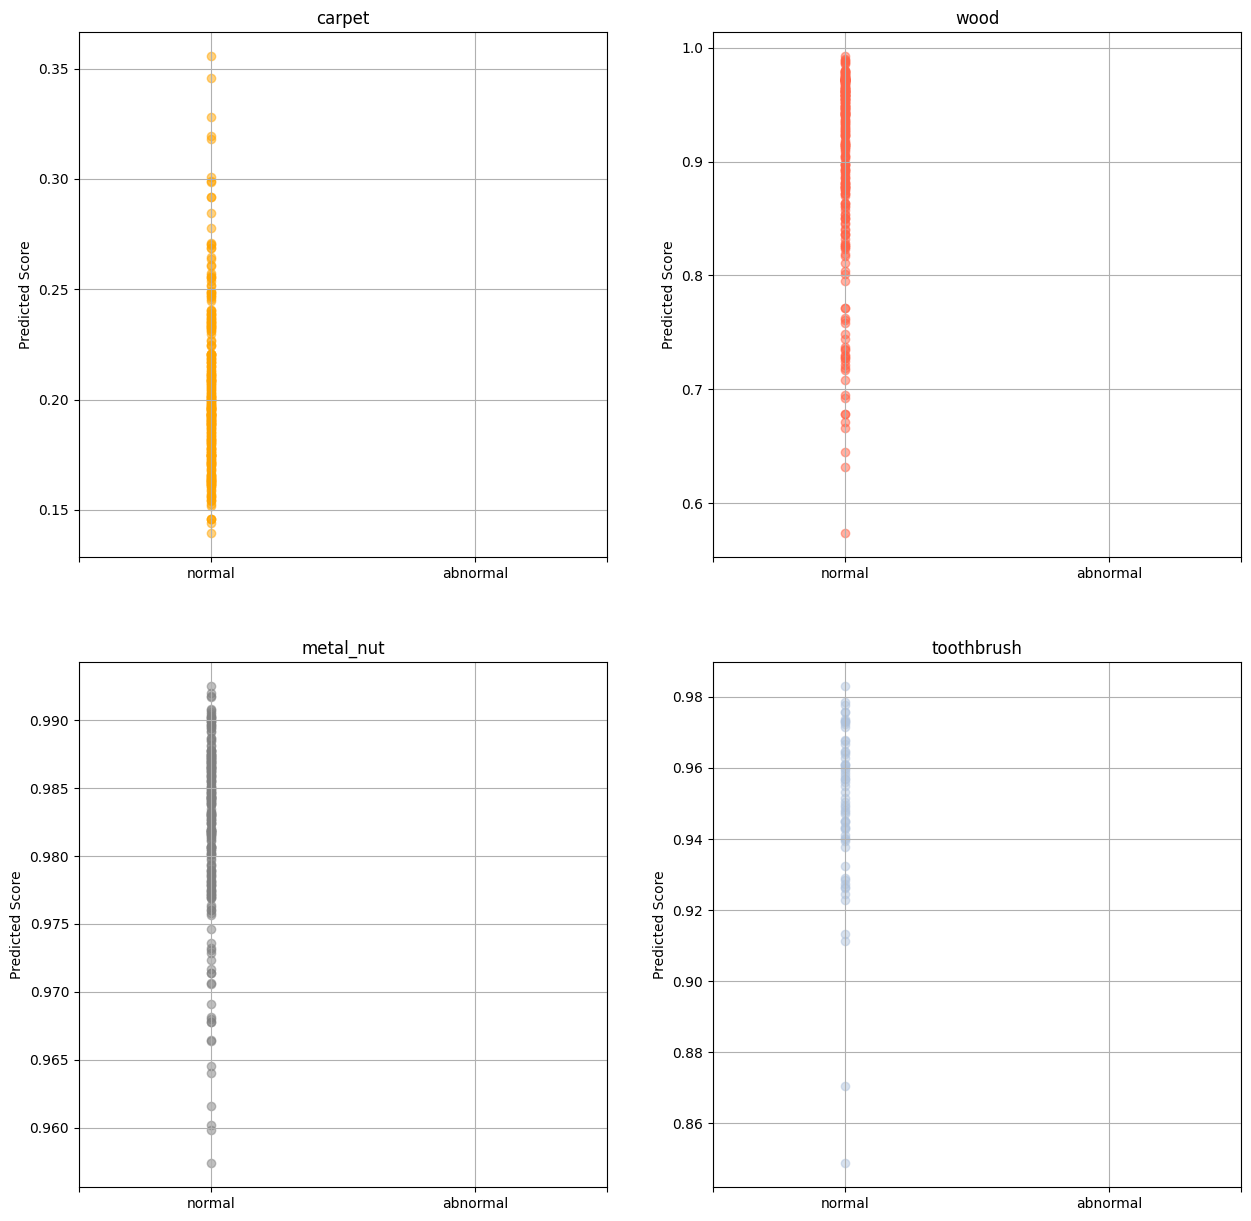

In [35]:
# train
plt.figure(figsize=(15, 15))
for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

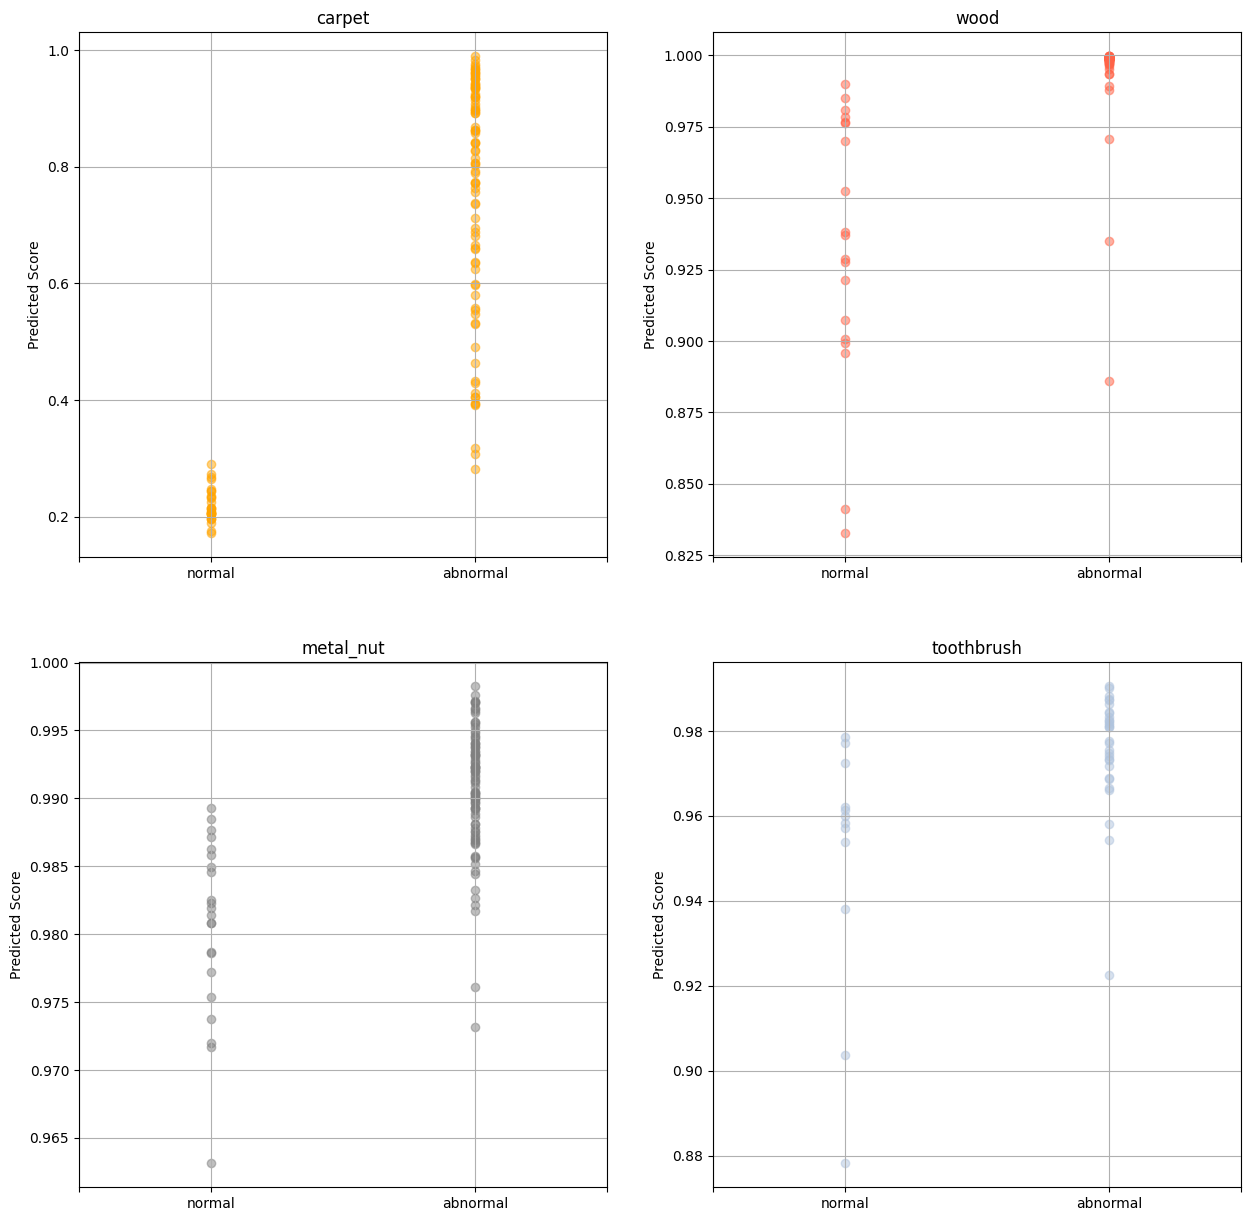

In [36]:
# test
plt.figure(figsize=(15, 15))
for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

### 2. qhat

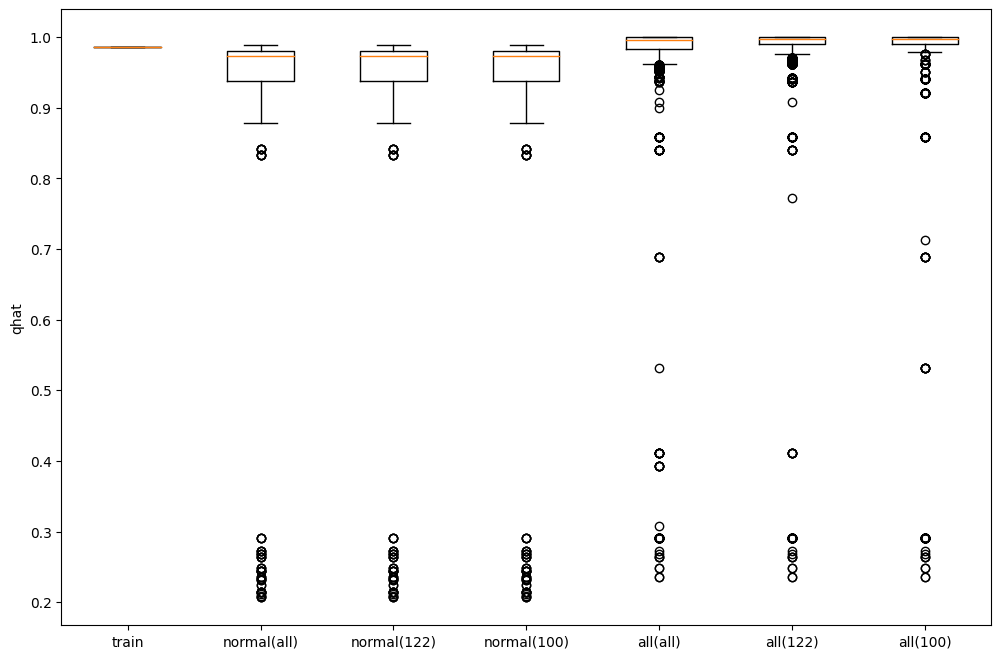

In [37]:
plt.figure(figsize=(12, 8))
# plt.boxplot(train_qhat, y=0)
plt.boxplot([train_qhat, normal_all_qhat, normal_122_qhat, normal_100_qhat, all_all_qhat, all_122_qhat, all_100_qhat])
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['train', 'normal(all)', 'normal(122)', 'normal(100)', 'all(all)', 'all(122)', 'all(100)'])
plt.ylabel('qhat')
plt.show()

---
# 5. conformal p-value

#### 4. Computing marginal conformal p-values

In [38]:
from cccpv.models import ToyModel
from cccpv.methods import ConformalPvalues
from cccpv.methods import calibrate_ccv

In [39]:
scores_test = 1-np.array(y_score_list)
scores_cal = 1-np.array(scores)

scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

In [40]:
scores_test.shape

(353,)

In [41]:
is_outlier = np.zeros(len(scores_test))
is_outlier[np.where(y_true_np == 1)[0]] = 1
print(np.where(y_true_np == 1)[0])
print(is_outlier)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 31

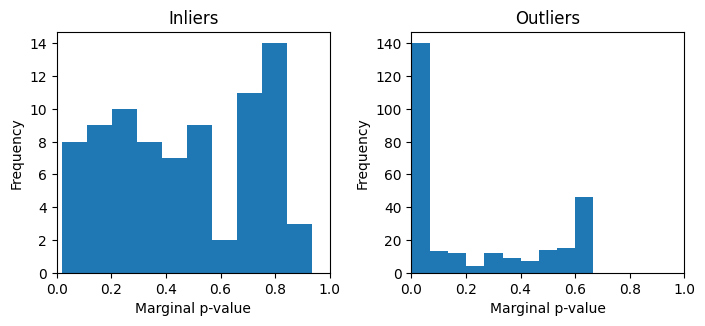

In [42]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal[is_outlier==0])
axs[0].set_xlabel("Marginal p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal[is_outlier==1])
axs[1].set_xlabel("Marginal p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

In [54]:
pred_pvals_marginal = pvals_marginal<0.05

p = precision_score(y_true_np, pred_pvals_marginal, zero_division=0)

r = recall_score(y_true_np, pred_pvals_marginal, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.978
recall: 0.489


In [58]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        y_pred = pvals_marginal < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal[y_label==0])
        axs[0].set_xlabel("Marginal p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal[y_label==1])
        axs[1].set_xlabel("Marginal p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./cal_p_/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 81 
전체개수 ===> 353 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.8722 
recall: 0.7028


---25---
precision: 0.8767 
recall: 0.6763


---30---
precision: 0.8814 
recall: 0.6479


---35---
precision: 0.8886 
recall: 0.632


---40---
precision: 0.8972 
recall: 0.6237


---45---
precision: 0.9057 
recall: 0.6088


---50---
precision: 0.9151 
recall: 0.5949


---55---
precision: 0.9254 
recall: 0.582




In [60]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]
remove_indices = random.sample(y_true_1_indices, 172)

y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1 - np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        y_pred = pvals_marginal < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal[y_label==0])
        axs[0].set_xlabel("Marginal p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal[y_label==1])
        axs[1].set_xlabel("Marginal p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./cal_p_mvtec_100/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 81 
전체개수 ===> 181 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.7264 
recall: 0.7134


---25---
precision: 0.7351 
recall: 0.6879


---30---
precision: 0.7441 
recall: 0.6598


---35---
precision: 0.7573 
recall: 0.6435


---40---
precision: 0.7735 
recall: 0.6351


---45---
precision: 0.789 
recall: 0.6175


---50---
precision: 0.8065 
recall: 0.6003


---55---
precision: 0.8266 
recall: 0.5842




##### Benjamini-Hochberg 


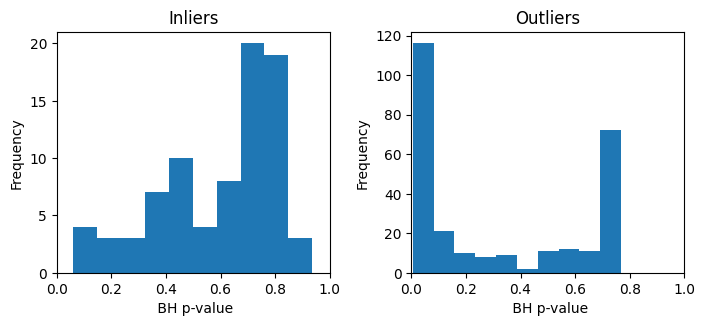

In [50]:
pvals_marginal_sorted = np.sort(pvals_marginal)
m = len(pvals_marginal)

pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
# pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

pvals_marginal_bh_full = np.empty_like(pvals_marginal)
pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal_bh_full[is_outlier==0])
axs[0].set_xlabel(" BH p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal_bh_full[is_outlier==1])
axs[1].set_xlabel(" BH p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

In [57]:
pred_marginal_bh_full = pvals_marginal_bh_full<0.05

p = precision_score(y_true_np, pred_marginal_bh_full, zero_division=0)

r = recall_score(y_true_np, pred_marginal_bh_full, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 1.0
recall: 0.379


In [59]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        pvals_marginal_sorted = np.sort(pvals_marginal)
        m = len(pvals_marginal)

        pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
        # pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

        pvals_marginal_bh_full = np.empty_like(pvals_marginal)
        pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

        y_pred = pvals_marginal_bh_full < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal_bh_full[y_label==0])
        axs[0].set_xlabel("Marginal p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal_bh_full[y_label==1])
        axs[1].set_xlabel("Marginal p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./bh_p_mvtec/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 81 
전체개수 ===> 353 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.1475 
recall: 0.0064


---25---
precision: 0.2128 
recall: 0.0259


---30---
precision: 0.4015 
recall: 0.0493


---35---
precision: 0.4373 
recall: 0.0571


---40---
precision: 0.4302 
recall: 0.0686


---45---
precision: 0.6694 
recall: 0.1187


---50---
precision: 0.7983 
recall: 0.1589


---55---
precision: 0.8434 
recall: 0.1899




In [61]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]
remove_indices = random.sample(y_true_1_indices, 172)

y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        pvals_marginal_sorted = np.sort(pvals_marginal)
        m = len(pvals_marginal)

        pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
        # pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

        pvals_marginal_bh_full = np.empty_like(pvals_marginal)
        pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

        y_pred = pvals_marginal_bh_full < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal_bh_full[y_label==0])
        axs[0].set_xlabel("BH p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal_bh_full[y_label==1])
        axs[1].set_xlabel("BH p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./bh_p_mvtec_100/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 81 
전체개수 ===> 181 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.0064 
recall: 0.0005


---25---
precision: 0.0632 
recall: 0.0146


---30---
precision: 0.0291 
recall: 0.0071


---35---
precision: 0.0758 
recall: 0.0207


---40---
precision: 0.2615 
recall: 0.0417


---45---
precision: 0.281 
recall: 0.0633


---50---
precision: 0.4381 
recall: 0.1039


---55---
precision: 0.5588 
recall: 0.1412




---
# 6. FPR control

#### 4. Compute a calibration curve

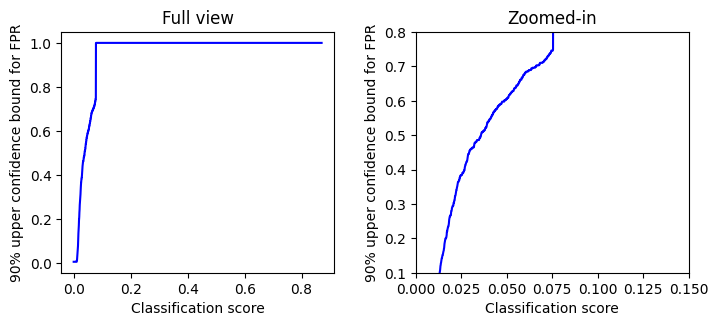

In [47]:
from cccpv.methods import CalibrationBound

# scores_test = np.array(y_score_list)
# scores_cal = np.array(scores)

# Initialize upper FPR band
cband = CalibrationBound(scores_cal, delta=0.1)

# Evaluate the bound on a grid of values
x_grid = np.arange(np.min(scores_cal)-0.01, np.max(scores_cal)+0.01, 0.0001)
bound_y, _ = cband.evaluate(x_grid)

# Plot the bound
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].plot(x_grid, bound_y, label="upper confidence bound", linestyle="-", color="blue")
axs[0].set_xlabel("Classification score")
axs[0].set_ylabel("90% upper confidence bound for FPR")
axs[0].title.set_text('Full view')

axs[1].plot(x_grid, bound_y, label="upper confidence bound", linestyle="-", color="blue")
axs[1].set_xlabel("Classification score")
axs[1].set_ylabel("90% upper confidence bound for FPR")
axs[1].set_xlim([0, 0.15])
axs[1].set_ylim([0.1, 0.8])
axs[1].title.set_text('Zoomed-in')

plt.show()


#### 5. Validate on test data


In [48]:
from statsmodels.distributions.empirical_distribution import ECDF

## Compute empirical FPR for test data
scores_test = train_results['orange']['pr_sp']

# Evaluate empirical CDF on test scores
ecdf = ECDF(scores_test)
empirical_fpr = ecdf(x_grid)

# Evaluate the bound on this grid of values
bound_y, _ = cband.evaluate(x_grid)

# Compute the true FPR curve using Monte Carlo
scores_mc = np.sort(test_results['orange']['pr_sp'])
ecdf = ECDF(scores_mc)
true_fpr = ecdf(x_grid)

# Compare the bound to the empirical FPR
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].plot(x_grid, bound_y, label="90% UCB", linestyle="-", color="blue")
axs[0].plot(x_grid, empirical_fpr, label="empirical", linestyle=":", color="red")
axs[0].plot(x_grid, true_fpr, label="true", linestyle="--", color="black")
axs[0].set_xlabel("Classification score")
axs[0].set_ylabel("FPR")
axs[0].title.set_text('Full view')

axs[1].plot(x_grid, bound_y, label="90% UCB", linestyle="-", color="blue")
axs[1].plot(x_grid, empirical_fpr, label="empirical", linestyle=":", color="red")
axs[1].plot(x_grid, true_fpr, label="true", linestyle="--", color="black")
axs[1].set_xlabel("Classification score")
axs[1].set_ylabel("FPR")
axs[1].set_xlim([0.01, 0.02])
# axs[1].set_ylim([0,0.1])
axs[1].title.set_text('Zoomed-in')

plt.legend()
plt.show()

KeyError: 'orange'